<a href="https://colab.research.google.com/github/hailuu684/ComputerVisionHomeWork/blob/semantic_segmentation/Unet_CV_homework_750images_50epochs_accuracyMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import cv2
import keras
# from tensorflow.keras import layers
from matplotlib import pyplot as plt
# from tensorflow.keras.applications.vgg16 import VGG16



from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from skimage.segmentation import mark_boundaries
from keras.models import Model

from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation,DepthwiseConv2D, add
from keras.layers import AveragePooling2D, Concatenate
from keras.engine import Layer,InputSpec
from keras.utils import conv_utils


from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
from skimage import io
# from data import load_train_data, load_test_data

In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/utils
import helpers

rgb_dir='/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/rgb'
seg_dir='/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/seg'

images_path = list(sorted([ os.path.join(rgb_dir, fname) for fname in os.listdir(rgb_dir) ]))
segmentations_path = list(sorted([ os.path.join(seg_dir, fname) for fname in os.listdir(seg_dir)]))

raw_label_mapping = {  
     0: [0, 0, 0],         # None 
     1: [70, 70, 70],      # Buildings 
     2: [190, 153, 153],   # Fences 
     3: [72, 0, 90],       # Other 
     4: [220, 20, 60],     # Pedestrians 
     5: [153, 153, 153],   # Poles 
     6: [157, 234, 50],    # RoadLines 
     7: [128, 64, 128],    # Roads 
     8: [244, 35, 232],    # Sidewalks 
     9: [107, 142, 35],    # Vegetation 
     10: [0, 0, 142],      # Vehicles  0 0 255
     11: [102, 102, 156],  # Walls 
     12: [220, 220, 0],     # TrafficSigns 
     13: [70, 130, 180],  #Sky
     14: [81,   0,  81],   #ground
     15: [150, 100, 100],    #Bridge
     16: [250, 170,  30],  #Traffic light
     17: [145, 170, 100] #Terrain
 } 

def label_image(label_img,raw_label_mapping):
  test = np.zeros([512,1024,3])
  for key,value in raw_label_mapping.items():
    equality = np.equal(label_img,value)
    test[label_img == value] = key
  test = test[:,:,1]
  return test

import random
num_images = 750
val_samples = int(num_images*0.8)
images=[]
annotations=[]
annotations_oneHot = []
classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/classes_added_more_classes.csv')
for i in range(num_images):
    img1,label_img_1 = cv2.imread(images_path[i]),cv2.imread(segmentations_path[i])#[:,:,2]
    img=cv2.resize(img1,(512,512,))
    label_img_1 = cv2.cvtColor(label_img_1,cv2.COLOR_BGR2RGB)
    # mask1 = np.zeros((512,1024,3),np.uint8)
    # mask1 = label_image(label_img_1,raw_label_mapping)
    label_img_1 = cv2.resize(label_img_1,(512,512,))
    
    mask_oneHot = np.float32(helpers.one_hot_it(label_img_1,label_values))
    # mask_oneHot = cv2.resize(mask_oneHot,(512,512))
    # mask_oneHot_resize = cv2.resize(mask_oneHot,(512,512))

    mask1 = helpers.reverse_one_hot(mask_oneHot)
    # mask1_resize = cv2.resize(mask1,(512,512))
    images.append(img)
    annotations.append(mask1)
    # annotations_oneHot.append(mask_oneHot)
images=np.array(images)
annotations = np.array(annotations)
# annotations_oneHot = np.array(annotations_oneHot)

/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/utils


In [3]:
num_class = len(label_values)
num_class

23

In [5]:
annotations[1]

array([[13, 13, 13, ...,  1,  1,  1],
       [13, 13, 13, ...,  1,  1,  1],
       [13, 13, 13, ...,  1,  1,  1],
       ...,
       [ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  7,  7,  7]])

In [6]:
# For annotations with the keys for each color
shuffle_images = num_images
random.Random(shuffle_images).shuffle(images)
random.Random(shuffle_images).shuffle(annotations)
train_data=images[:-val_samples]
train_annotate=annotations[:-val_samples]
valid_data=images[-val_samples:]
valid_annotate=annotations[-val_samples:]

# # For one hot annotations
# shuffle_images = num_images
# random.Random(shuffle_images).shuffle(images)
# random.Random(shuffle_images).shuffle(annotations_oneHot)
# train_data=images[:-val_samples]
# train_annotate_oneHot=annotations_oneHot[:-val_samples]
# valid_data=images[-val_samples:]
# valid_annotate_ontHot=annotations_oneHot[-val_samples:]

In [69]:
valid_data.shape, valid_annotate.shape

((80, 256, 256, 3), (80, 256, 256))

In [ ]:
# from tensorflow import keras
# from tensorflow.keras import layers

# data_augmentation = keras.Sequential(
#     [
#         layers.experimental.preprocessing.RandomFlip("horizontal"),
#         layers.experimental.preprocessing.RandomRotation(0.1),
#     ]
# )

In [7]:
from keras import regularizers

In [8]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
      inputs = keras.Input(shape=img_size + (3,))

      ### [First half of the network: downsampling inputs] ###

      # Entry block
      x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
      x = layers.BatchNormalization()(x)
      x = layers.Activation("relu")(x)

      previous_block_activation = x  # Set aside residual

      # Blocks 1, 2, 3 are identical apart from the feature depth.
      for filters in [64, 128, 256]:
          x = layers.Activation("relu")(x)
          x = layers.SeparableConv2D(filters, 3, padding="same")(x)
          x = layers.BatchNormalization()(x)

          x = layers.Activation("relu")(x)
          x = layers.SeparableConv2D(filters, 3, padding="same")(x)
          x = layers.BatchNormalization()(x)

          x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

          # Project residual
          residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
              previous_block_activation
          )
          x = layers.add([x, residual])  # Add back residual
          previous_block_activation = x  # Set aside next residual

      ### [Second half of the network: upsampling inputs] ###

      for filters in [256, 128, 64, 32]:
          x = layers.Activation("relu")(x)
          x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
          x = layers.BatchNormalization()(x)

          x = layers.Activation("relu")(x)
          x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
          x = layers.BatchNormalization()(x)

          x = layers.UpSampling2D(2)(x)

          # Project residual
          residual = layers.UpSampling2D(2)(previous_block_activation)
          residual = layers.Conv2D(filters, 1, padding="same")(residual)
          x = layers.add([x, residual])  # Add back residual
          previous_block_activation = x  # Set aside next residual

      # Add a per-pixel classification layer
      outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
# ,kernel_regularizer=regularizers.l2(0.01),
#                               activity_regularizer=regularizers.l2(0.01)
      # Define the model
      model = keras.Model(inputs, outputs)
      return model

In [66]:
from keras import backend as K

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [54]:
from tensorflow.keras.losses import binary_crossentropy

def dice_coef(y_true,y_pred):
    y_true_f=K.flatten(y_true)
    y_pred_f=K.flatten(y_pred)
    intersection=K.sum(y_true_f*y_pred_f)
    return (2.0*intersection+1.0)/(K.sum(y_true_f)+K.sum(y_pred_f)+1.0)


def dice_coef_loss(y_true,y_pred):
    return -dice_coef(y_true,y_pred)


In [ ]:
# # img_rows = int(512/2)
# # img_cols = int(512/2)
# smooth = 1
# def preprocess(imgs):
#     imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
#     for i in range(imgs.shape[0]):
#         imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

#     imgs_p = imgs_p[..., np.newaxis]
#     return imgs_p

In [ ]:
# imgs_mask_train = preprocess(annotations)

# imgs_train = images.astype('float32')
# mean = np.mean(imgs_train)  # mean for data centering
# std = np.std(imgs_train)  # std for data normalization

# imgs_train -= mean
# imgs_train /= std
# #Normalization of the train set

# imgs_mask_train = imgs_mask_train.astype('float32')


In [ ]:
images.shape, annotations.shape

((30, 256, 256, 3), (30, 256, 256))

In [ ]:
np.unique(annotations[12])

array([ 1,  4,  5,  6,  7,  8, 10, 11, 13, 14, 16, 18, 20, 22],
      dtype=int32)

In [ ]:
annotations_expandDim = np.expand_dims(annotations_oneHot,axis=-1)
print(annotations_oneHot.shape)

(100, 256, 256, 13)


In [72]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    vertical_flip=True,
    data_format="channels_last")

model_1 = get_model((annotations[0].shape[0],annotations[0].shape[1]), num_class)
# model_deepLab = deeplabv3_plus((img_h, img_w,3),num_classes=num_class)
metrics = keras.metrics.MeanIoU(num_classes=num_class)
model_1.compile(optimizer="Adam", loss=jaccard_distance_loss, metrics=[metrics])

datagen.fit(images)
callbacks = [
    keras.callbacks.ModelCheckpoint("test.h5", save_best_only=True),
    keras.callbacks.LearningRateScheduler(scheduler),
    keras.callbacks.EarlyStopping(monitor='val_loss',patience=8)
]

history = model_1.fit(datagen.flow(images, annotations_oneHot, batch_size=32,
         subset='training'),
         validation_data=datagen.flow(images, annotations_oneHot,
         batch_size=32, subset='validation'),
          steps_per_epoch=len(images) / 64, epochs=20,callbacks=callbacks)



Epoch 1/20
1/1 [==============================] - 51s 48s/step - loss: 354.5485 - mean_io_u_7: 0.4793 - val_loss: 50.3557 - val_mean_io_u_7: 0.4791
Epoch 2/20
1/1 [==============================] - 48s 46s/step - loss: 402.6499 - mean_io_u_7: 0.4791 - val_loss: 71.6237 - val_mean_io_u_7: 0.4791
Epoch 3/20
1/1 [==============================] - 38s 47s/step - loss: 442.7924 - mean_io_u_7: 0.4793 - val_loss: 98.0007 - val_mean_io_u_7: 0.4791
Epoch 4/20
1/1 [==============================] - 47s 46s/step - loss: 429.5038 - mean_io_u_7: 0.4793 - val_loss: 132.8411 - val_mean_io_u_7: 0.4791
Epoch 5/20
1/1 [==============================] - 37s 46s/step - loss: 374.0099 - mean_io_u_7: 0.4794 - val_loss: 252.2636 - val_mean_io_u_7: 0.4791
Epoch 6/20
1/1 [==============================] - 47s 46s/step - loss: 322.7511 - mean_io_u_7: 0.4794 - val_loss: 309.1831 - val_mean_io_u_7: 0.4791
Epoch 7/20
1/1 [==============================] - 37s 46s/step - loss: 263.2185 - mean_io_u_7: 0.4793 - val_l

In [12]:
import math
import tensorflow as tf
def scheduler(epoch, lr):
    if epoch < 10:
      return lr
    else:
      return lr * math.exp(-0.1)
img_h = annotations[0].shape[0]
img_w = annotations[0].shape[1]
# dropout_rate = 0.5
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.9)
model_1 = get_model((annotations[0].shape[0],annotations[0].shape[1]), num_classes=len(label_values))
# model_deepLab = deeplabv3_plus((img_h, img_w,3),num_classes=num_class)
# metrics = keras.metrics.MeanIoU(num_classes=num_class)
# model_1.compile(optimizer="Adam", loss=dice_coef_loss, metrics=[metrics])
# callbacks = [
#     keras.callbacks.ModelCheckpoint("test.h5", save_best_only=True),
#     keras.callbacks.LearningRateScheduler(scheduler),
#     keras.callbacks.EarlyStopping(monitor='val_loss',patience=8)
# ]


model_1.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("test.h5", save_best_only=True),
    keras.callbacks.LearningRateScheduler(lr_schedule),
    keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=8)
]

history=model_1.fit(images,annotations,batch_size=16, epochs = 50 ,callbacks=callbacks,validation_split=0.2,shuffle=True)

Epoch 1/50
38/38 [==============================] - 50s 1s/step - loss: 3.2007 - accuracy: 0.4599 - val_loss: 9.0791 - val_accuracy: 0.0680
Epoch 2/50
38/38 [==============================] - 45s 1s/step - loss: 1.0098 - accuracy: 0.6870 - val_loss: 2.7184 - val_accuracy: 0.2786
Epoch 3/50
38/38 [==============================] - 46s 1s/step - loss: 0.8139 - accuracy: 0.7459 - val_loss: 2.8721 - val_accuracy: 0.2821
Epoch 4/50
38/38 [==============================] - 46s 1s/step - loss: 0.7583 - accuracy: 0.7608 - val_loss: 3.5201 - val_accuracy: 0.2752
Epoch 5/50
38/38 [==============================] - 46s 1s/step - loss: 0.7878 - accuracy: 0.7546 - val_loss: 3.9321 - val_accuracy: 0.2706
Epoch 6/50
38/38 [==============================] - 46s 1s/step - loss: 0.6630 - accuracy: 0.7903 - val_loss: 3.9801 - val_accuracy: 0.2859
Epoch 7/50
38/38 [==============================] - 46s 1s/step - loss: 0.5977 - accuracy: 0.8123 - val_loss: 3.9464 - val_accuracy: 0.2907
Epoch 8/50
38/38 [==

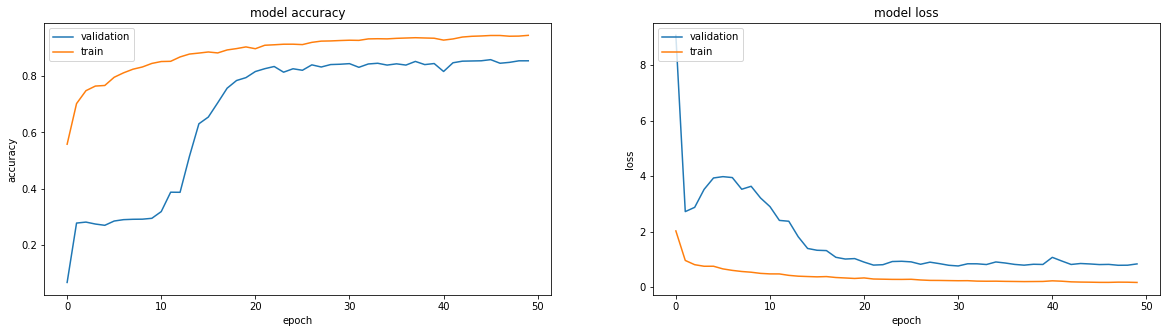

In [15]:
# summarize history for accuracy
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation', 'train'], loc='upper left')
plt.savefig('Model_accuracy.png')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'train'], loc='upper left')
plt.savefig('Model_loss.png')

# # summarize history for accuracy
# plt.plot(history.history['val_mean_io_u_3'])
# plt.plot(history.history['mean_io_u_3'])
# plt.title('model mean accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

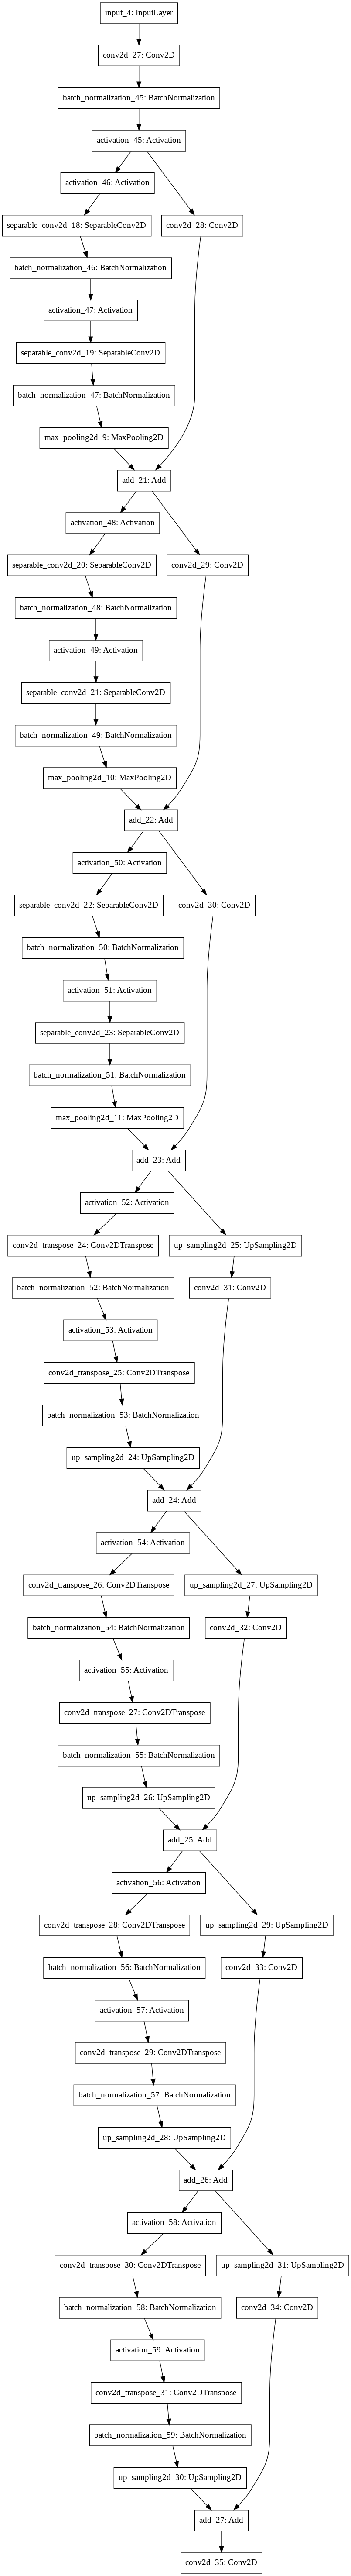

In [ ]:
keras.utils.plot_model(model_1, "my_first_model.png")

In [ ]:
from keras.models import load_model

In [ ]:
model_1 = get_model((256,256), 13)
model_test = model_1.load_weights('test.h5')

ValueError: ignored

In [ ]:
path_test = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/rgb/00.jpg'
imgs_test = cv2.imread(path_test)
imgs_test = cv2.resize(imgs_test,(256,256))
imgs_test = np.expand_dims(imgs_test,axis=0)
imgs_test.shape

(1, 256, 256, 3)

In [ ]:
imgs_mask_test = model_1.predict(imgs_test)
imgs_mask_test.shape

(1, 256, 256, 13)

In [ ]:
np.unique(imgs_mask_test)

array([0.0243769 , 0.02477916, 0.02486597, ..., 0.17722403, 0.18078879,
       0.19093959], dtype=float32)

In [ ]:
newimg = np.zeros((256,256))
#print(pred)
for i in range(13):
    for j in range(256):
        for k in range(256):
            if imgs_mask_test[0,j,k,i] > 0.4:
                newimg[j,k] = i

In [ ]:
newimg11

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

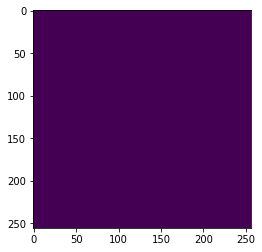

In [ ]:
plt.imshow(newimg)

In [ ]:
type(newimg)

numpy.ndarray

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/utils/unet_segmentation_metrics/umetrics
# sys.path.append('..')
import core

/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/utils/unet_segmentation_metrics/umetrics


<class 'numpy.ndarray'>


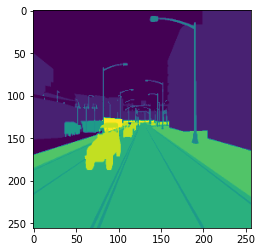

In [ ]:
path_seg = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data/seg/00.png'
label_img = cv2.imread(path_seg)
classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/Semantic-Segmentation-Suite/CamVid/classes.csv')
label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)

mask_iou = label_image(label_img,raw_label_mapping)
mask_iou = cv2.resize(mask_iou,(256,256,))
# mask_iou = helpers.reverse_one_hot(mask_iou)
print(type(mask_iou))
plt.imshow(mask_iou)

In [ ]:
metrics = core.calculate(mask_iou,newimg,strict=True, iou_threshold=0.4)
print(metrics.results)

 Segmentation Metrics (n=1)
Strict: True (IoU > 0.4)
n_true_labels: 13
n_pred_labels: 9
n_true_positives: 0
n_false_positives: 6
n_false_negatives: 11
IoU: nan
Jaccard: 0.000
pixel_identity: 0.918
localization_error: nan



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data
import seg_metrics

/content/drive/MyDrive/Colab Notebooks/Test_segmentation/test_seg_data/prof_data


In [ ]:
expand = np.expand_dims(mask_iou,axis=0)
expand = np.expand_dims(expand,axis=-1)
expand.shape
expand_pred = np.expand_dims(newimg,axis=0)
expand_pred = np.expand_dims(expand_pred,axis=-1)

In [ ]:
iou = seg_metrics.mean_iou_np(expand,expand_pred)
iou

0.9619950543694341

# find x,y,z coordinates from depth images

In [ ]:

def xy_from_depth(depth, k):

   
    # Get the shape of the depth tensor
    depth_shape = depth.shape

    # Grab required parameters from the K matrix
    f  = k[0][0]
    px = k[0][2]
    py = k[1][2]

    
    # Generate a grid of coordinates corresponding to the shape of the depth map
    u = np.indices(depth_shape)[1]
    v = np.indices(depth_shape)[0]

    # Compute x and y coordinates
    x = np.multiply(u - px, depth)/f
    y = np.multiply(-v + py, depth)/f

    
    return x, y

In [ ]:
rgb_img_path = '/content/drive/MyDrive/Colab Notebooks/Test_self_train_yolo_v4/test_3d_detection/06.jpg'
depth_path = '/content/drive/MyDrive/Colab Notebooks/Test_self_train_yolo_v4/test_3d_detection/06.png'
img = cv2.imread(rgb_img_path)
depth_img = cv2.imread(depth_path,-1)
depth_img = depth_img/100.0

In [ ]:
#creating empty image of same size
height, width, no_use = img.shape
empty_img = np.zeros((height, width), np.uint8)

In [ ]:
#APPLIED K-MEANS CLUSTERING
Z = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 6
ret,label,center=cv2.kmeans(Z,K,None,criteria,15,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

In [ ]:
#CONVERTED TO A LUV IMAGE AND MADE EMPTY IMAGE, A MASK
blur = cv2.GaussianBlur(res2,(7,7),0)
gray = cv2.cvtColor(cv2.UMat(blur),cv2.COLOR_RGB2GRAY)
LUV = cv2.cvtColor(blur,cv2.COLOR_RGB2LUV)
l = LUV[:,:,0]
v1 = l>80
v2 = l<150
value_final = v1 & v2 
empty_img[value_final] = 255
empty_img[LUV[:,:100,:]] = 0

In [ ]:
#APPLIED BITWISE-AND ON GRAYSCALE IMAGE AND EMPTY IMAGE TO OBTAIN ROAD AND SOME-OTHER IMAGES TOO
final = cv2.bitwise_and(gray,empty_img)
contours, hierarchy = cv2.findContours(final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(final, contours, -1, 0, 3)

<UMat 0x7f121faaa330>

In [ ]:
img_array = cv2.UMat.get(final)
np.max(img_array)

143

In [ ]:
#FURTHER MASKED THE FINAL IMAGE TO OBTAIN ONLY THE ROAD PARTICLES
final_masked = np.zeros((height, width), np.uint8)
v1 = img_array >=100
v2 = img_array <=120
#v3 = final == 78    
final_masked[v1 & v2] = 255

In [ ]:
#APPLIED EROSION,CONTOURS AND TOP-HAT TO REDUCE NOISE
kernel = np.ones((3,3),np.uint8)
final_eroded = cv2.erode(final_masked,kernel,iterations=1) 
contours, hierchary = cv2.findContours(final_eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
final_masked = cv2.drawContours(final_eroded, contours, -1, 0, 3)
   
final_waste = cv2.morphologyEx(final_masked,cv2.MORPH_TOPHAT,kernel, iterations = 2) 
final_waste = cv2.bitwise_not(final_waste)
final_masked = cv2.bitwise_and(final_waste,final_masked)

In [ ]:
#MADE A LINE ON THE LEFT-BOTTOM OF THE PAGE
final_masked = cv2.line(final_masked,(40,height),(400,height),255,100)

In [ ]:
#USED FLOOD-FILL TO FILL IN THE SMALL BLACK LANES
final_flood = final_masked.copy()
h, w = final_masked.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(final_flood,mask,(0,0),255)
final_flood = cv2.bitwise_not(final_flood)
final_filled= cv2.bitwise_or(final_masked,final_flood)

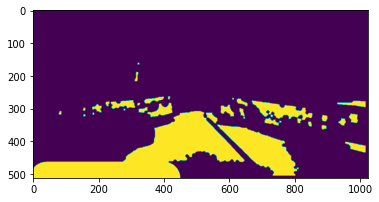

In [ ]:
plt.imshow(final_filled)

In [ ]:
img[final_filled==255] = (255,60,60)


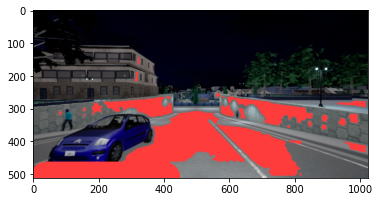

In [ ]:

plt.imshow(img)

# Test codes from github

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/drivable_area_detection
import utilities
import freespace
import stereo

/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/drivable_area_detection


In [ ]:
left_path = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/drivable_area_detection/left.png'
right_path = '/content/drive/MyDrive/Colab Notebooks/Test_segmentation/free_space_woutDeepLearning/drivable_area_detection/right.png'
l_img = cv2.imread(left_path)
r_img = cv2.imread(right_path)

In [ ]:
v,u,depth_map,project = freespace.get_free_bound(l_img,r_img)

In [ ]:
def all_idx(idx, axis):
    '''
    to get the necessary indices
    '''
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)

In [ ]:
ncols = depth_map.max()+1
out = np.zeros(depth_map.shape + (ncols,), dtype=int)
out[all_idx(depth_map, axis=2)] = 1

In [ ]:
v_disparity_thresh = v > 100
lines = np.squeeze(cv2.HoughLines(v_disparity_thresh.astype(np.uint8), 1, np.pi/180, 75))

In [ ]:
# extracting road planes in a certain range
line = lines[(lines[:, 1] > 1.5) * (lines[:, 1] < 3.0), :]

In [ ]:
# if no line matches the criteria, just give out the first found line
if line.size == 0:
    line = lines[0]
else:  # else give the first line that matches the criteria
    line = line[0]
# extract the radius and angle defining the line
    rho = line[0]
    theta = line[1]

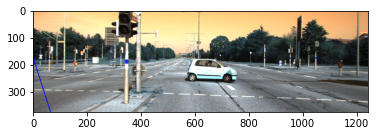

In [ ]:
a = np.cos(theta)
b = np.sin(theta)
x0 = a*rho
y0 = b*rho
x1 = int(x0 + 1000*(-b))
y1 = int(y0 + 1000*(a))
x2 = int(x0 - 1000*(-b))
y2 = int(y0 - 1000*(a))

cv2.line(l_img,(x1,y1),(x2,y2),(0,0,255),2)
plt.imshow(l_img)

test image from fb

In [ ]:
path_fb = '/content/drive/MyDrive/Google colab notebooks/test.jpg'

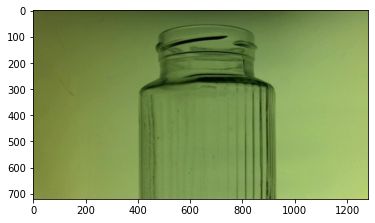

In [ ]:
img = cv2.imread(path_fb)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


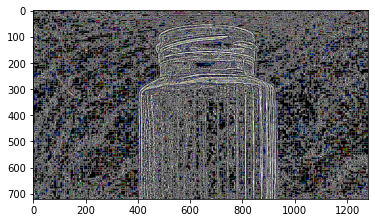

In [ ]:
laplacian = cv2.Laplacian(img,cv2.CV_32F)
plt.imshow(laplacian)

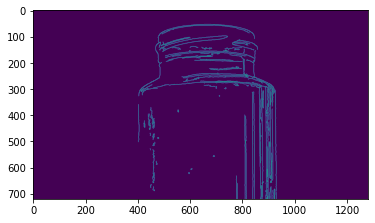

In [ ]:
gray = cv2.imread(path_fb,0)
gray = cv2.cvtColor(gray,cv2.COLOR_BGR2RGB)
cany = cv2.Canny(gray,50,100)
plt.imshow(cany)

In [ ]:
cany.shape

(720, 1280)

In [ ]:
height,width = cany.shape
for i in range(width):
  for j in range(height):
    if cany[j,i] == 0:
      cany[j,i] = 1
    else:
      cany[j,i] = 0
  #take the center of the image, then calculate the distance from center to the edge
  # on the left(because it is not distored by the other edge)
  # then draw the bbx

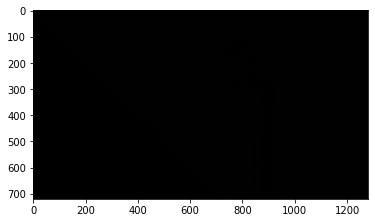

In [ ]:
cany = cv2.cvtColor(cany,cv2.COLOR_BGR2RGB)
plt.imshow(cany)


Idea: for training yoloV4, all images and labels have to put in 1 files, and they have to have the same name

In [ ]:
# path_train = Path('/content/drive/MyDrive/Google colab notebooks/ComputerVision_homework/Carla_Videos/rgb(test)')
# for i in range(len(X_train_val)):
#   img = X_train_val[i]
#   label = Y_train_val[i]
#   cv2.imwrite(path_train,img)
  